In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import scipy.integrate as scpi
import scipy.interpolate as sci

import os 
import json

import cbmos
import cbmos.force_functions as ff
import cbmos.solvers.euler_forward as ef
import cbmos.solvers.euler_backward as eb
import cbmos.cell as cl
import cbmos.utils as ut
import cbmos.events as ev

plt.style.use('seaborn-whitegrid')
plt.style.use('tableau-colorblind10')
params = {'legend.fontsize': 'xx-large',
          'figure.figsize': (6.75, 5),
          'lines.linewidth': 3.0, 
          'axes.labelsize': 'xx-large',
          'axes.titlesize':'xx-large',
          'xtick.labelsize':'xx-large', 
          'ytick.labelsize':'xx-large', 
          'legend.fontsize': 'xx-large', 
          'font.size': 11, 
          'font.family': 'serif', 
          'mathtext.fontset': 'dejavuserif', 
          'axes.titlepad': 12, 
          'axes.labelpad': 12}
plt.rcParams.update(params)

from matplotlib import cm
import matplotlib.colors as mcolors

In [2]:
s = 1.0
rA = 1.5
params_cubic = {'mu': 5.7, 's': s, 'rA': rA}
dim = 3
seed = 67
tf = 1500.0 # in order to reach 1000 cells (starting at 512)
frequency = 3.0

In [3]:
#ancestor = [cl.Cell(0, [0.0, 0.0, 0.0])]

#start with tissue (~500 cells?)
coords = ut.generate_hcp_coordinates(8, 8, 8)
tissue = [cl.Cell(i, [x, y, z]) for i, (x, y, z) in enumerate(coords)]

event_times = np.arange(0.0, tf, frequency)

events = [ev.PickRandomCellToDivideEvent(time) for time in event_times]


In [6]:
target_cell_counts = [100, 200, 300, 400, 500, 600, 700, 800, 900]
max_execution_time = 10*60 # 10 minutes in seconds

In [7]:
#algorithms
algorithms = ['EF_glob_adap_acc', 'EF_glob_adap_stab' ,  'EF_local_adap', 'EB_global_adap' ]

models = {'EF_glob_adap_acc': cbmos.CBModel(ff.Cubic(), ef.solve_ivp, dim),
          'EF_glob_adap_stab': cbmos.CBModel(ff.Cubic(), ef.solve_ivp, dim),  
          'EF_local_adap': cbmos.CBModel(ff.Cubic(), ef.solve_ivp, dim), 
          'EB_global_adap': cbmos.CBModel(ff.Cubic(), eb.solve_ivp, dim) }

eta = 1e-4
eps = 0.01

params = {'EF_glob_adap_acc': {'eps': eps, 'eta': eta},
          'EF_glob_adap_stab': {'eps': eps, 'eta': eta, 
                                'jacobian': models['EF_glob_adap_stab'].jacobian, 'force_args': params_cubic, 
                                'always_calculate_Jacobian': True, 
                                #'calculate_eigenvalues': True
                               }, 
          'EF_local_adap': {'eps': eps, 'eta': eta, 
                            'jacobian': models['EF_local_adap'].jacobian, 'force_args': params_cubic, 
                            'always_calculate_Jacobian': True, 
                            'local_adaptivity': True, 'm0': 4, 
                            #'calculate_eigenvalues': True
                            'dim': dim, 
                            'rA': rA 
                           }, 
          'EB_global_adap': {'eps': eps, 'eta': eta, 'jacobian': models['EB_global_adap'].jacobian, 'force_args': params_cubic}
         }


labels = {'EF_glob_adap_acc': 'Alg. I (GAFE)', 
          'EF_glob_adap_stab': 'Alg. II (GAFES)' ,  
          'EF_local_adap': 'Alg. III (LAFE)', 
          'EB_global_adap': 'Alg. IV (GABE)'
         }

In [8]:
data = {}
for alg in algorithms:
    print(alg)
    ts, history = models[alg].simulate(tissue, 
                                      [0, tf], 
                                      params_cubic, 
                                      params[alg],  
                                      seed=seed, 
                                      event_list=events,
                                      n_target_cells=target_cell_counts,
                                      max_execution_time=max_execution_time,
                                      throw_away_history=True
                                     )
    data[alg] = np.array(models[alg].target_cell_count_checkpoints)


EF_glob_adap_acc
EF_glob_adap_stab
EF_local_adap
EB_global_adap


In [9]:
data['EB_global_adap']

array([[297.        , 100.        ,  12.227597  ],
       [597.        , 200.        ,  64.69224882],
       [897.        , 300.        , 196.68411398]])

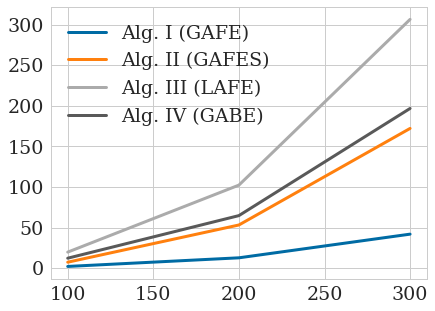

In [10]:
for alg in algorithms:
    plt.plot(data[alg][:, 1], data[alg][:, 2], label=labels[alg])
    
plt.legend()